In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torch.nn as nn

In [3]:
import sys
sys.path.append('/Users/dmitry/Desktop/Thesis/topics_ds/models')
sys.path.append('/Users/dmitry/Desktop/Thesis/topics_ds/data')
sys.path.append('/Users/dmitry/Desktop/Thesis/topics_ds/pytorch')

In [4]:
from data import data
from pytorch import torch_models, radam

Using TensorFlow backend.


In [5]:
IMG_LEN = 1024
TXT_LEN = 300
N_CLASSES = 50

### Data loading

In [6]:
x_img, x_txt, y = data.get_unpacked_data()

### Stratified train-val-test split

In [7]:
x_img_train, x_img_test, x_txt_train, x_txt_test, y_train, y_test = train_test_split(
    x_img, 
    x_txt, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

x_img_train, x_img_val, x_txt_train, x_txt_val, y_train, y_val = train_test_split(
    x_img_train,
    x_txt_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

### Standard Scaling

In [8]:
img_sscaler = StandardScaler()
img_sscaler.fit(x_img_train)

x_img_train = img_sscaler.transform(x_img_train)
x_img_val = img_sscaler.transform(x_img_val)
x_img_test = img_sscaler.transform(x_img_test)

txt_sscaler = StandardScaler()
txt_sscaler.fit(x_txt_train)

x_txt_train = txt_sscaler.transform(x_txt_train)
x_txt_val = txt_sscaler.transform(x_txt_val)
x_txt_test = txt_sscaler.transform(x_txt_test)

### Convert from numpy arrays to tensors

In [9]:
x_img_train_t = torch.tensor(x_img_train)
x_img_val_t = torch.tensor(x_img_val)
x_img_test_t = torch.tensor(x_img_test)

x_txt_train_t = torch.tensor(x_txt_train)
x_txt_val_t = torch.tensor(x_txt_val)
x_txt_test_t = torch.tensor(x_txt_test)

y_train_t = torch.tensor(y_train)
y_val_t = torch.tensor(y_val)
y_test_t = torch.tensor(y_test)

### Convert to TensorDataset

In [10]:
train_ds = TensorDataset(x_img_train_t, x_txt_train_t, y_train_t)
val_ds = TensorDataset(x_img_val_t, x_txt_val_t, y_val_t)
test_ds = TensorDataset(x_img_test_t, x_txt_test_t, y_test_t)

### Convert to DataLoader

In [11]:
# before 14.03.2020 it was 512
# experiments marked bs*number* is on batch_size == number
# otherwise batch_size == 512
BATCH_SIZE = 2048

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

### Trivial model

In [15]:
trivial_model = torch_models.TrivialModel()
optimizer = optim.Adam(trivial_model.parameters())
writer = SummaryWriter('runs/trivial_bs2048_rs42_')

EPOCHS = 60
for epoch in range(EPOCHS):
    
    trivial_model.train()
    
    loss_sum = 0.0
    loss_count = 0
    
    for x_img_cur, x_txt_cur, y_cur in train_loader:
        trivial_model.zero_grad()
        output = trivial_model(x_img_cur.view(-1, IMG_LEN).float(), x_txt_cur.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y_cur, dim=1))
        loss.backward()
            
        loss_sum += loss
        loss_count += 1
            
        optimizer.step()

    print('epoch:', epoch, 'train_loss:', loss, 'average train loss', loss_sum/loss_count)
    writer.add_scalar('train_loss', loss, epoch)
    writer.add_scalar('avg_train_loss', loss_sum/loss_count, epoch)

    trivial_model.eval()
    
    correct = 0
    total = 0
    loss_sum = 0.0
    loss_count = 0
        
    with torch.no_grad():
        for x_img_cur, x_txt_cur, y_cur in val_loader:
            output = trivial_model(x_img_cur.view(-1, IMG_LEN).float(), x_txt_cur.view(-1, TXT_LEN).float())
            loss = F.nll_loss(output, torch.argmax(y_cur, dim=1))
            loss_sum += loss
            loss_count += 1
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y_cur, dim=1)[idx]:
                    correct += 1
                total += 1

    print('val_acc:', correct/total, 'val_avg_loss:', loss_sum/loss_count)
    writer.add_scalar('val_acc', correct/total, epoch)
    writer.add_scalar('val_avg_loss', loss_sum/loss_count, epoch)

epoch: 0 train_loss: tensor(1.8746, grad_fn=<NllLossBackward>) average train loss tensor(2.3927, grad_fn=<DivBackward0>)
val_acc: 0.5617365710080942 val_avg_loss: tensor(1.6949)
epoch: 1 train_loss: tensor(1.5977, grad_fn=<NllLossBackward>) average train loss tensor(1.7040, grad_fn=<DivBackward0>)
val_acc: 0.5951140544518028 val_avg_loss: tensor(1.5169)
epoch: 2 train_loss: tensor(1.4508, grad_fn=<NllLossBackward>) average train loss tensor(1.5814, grad_fn=<DivBackward0>)
val_acc: 0.605121412803532 val_avg_loss: tensor(1.4628)
epoch: 3 train_loss: tensor(1.4213, grad_fn=<NllLossBackward>) average train loss tensor(1.5314, grad_fn=<DivBackward0>)
val_acc: 0.6111552612214863 val_avg_loss: tensor(1.4361)
epoch: 4 train_loss: tensor(1.3888, grad_fn=<NllLossBackward>) average train loss tensor(1.4942, grad_fn=<DivBackward0>)
val_acc: 0.613598233995585 val_avg_loss: tensor(1.4204)
epoch: 5 train_loss: tensor(1.3185, grad_fn=<NllLossBackward>) average train loss tensor(1.4700, grad_fn=<DivBac

epoch: 46 train_loss: tensor(0.8971, grad_fn=<NllLossBackward>) average train loss tensor(1.2510, grad_fn=<DivBackward0>)
val_acc: 0.6141574687270052 val_avg_loss: tensor(1.4155)
epoch: 47 train_loss: tensor(0.9027, grad_fn=<NllLossBackward>) average train loss tensor(1.2495, grad_fn=<DivBackward0>)
val_acc: 0.6129801324503311 val_avg_loss: tensor(1.4155)
epoch: 48 train_loss: tensor(0.9085, grad_fn=<NllLossBackward>) average train loss tensor(1.2514, grad_fn=<DivBackward0>)
val_acc: 0.6146284032376748 val_avg_loss: tensor(1.4158)
epoch: 49 train_loss: tensor(0.8776, grad_fn=<NllLossBackward>) average train loss tensor(1.2468, grad_fn=<DivBackward0>)
val_acc: 0.6132744665194997 val_avg_loss: tensor(1.4152)
epoch: 50 train_loss: tensor(0.9042, grad_fn=<NllLossBackward>) average train loss tensor(1.2454, grad_fn=<DivBackward0>)
val_acc: 0.6148050036791759 val_avg_loss: tensor(1.4168)
epoch: 51 train_loss: tensor(0.8625, grad_fn=<NllLossBackward>) average train loss tensor(1.2441, grad_fn

In [13]:
extreme_trivial_model = torch_models.ExtremeTrivialModel()
optimizer = optim.Adam(extreme_trivial_model.parameters())
writer = SummaryWriter('runs/extreme_trivial_bs2048_rs42')

EPOCHS = 60
for epoch in range(EPOCHS):
    loss_sum = 0.0
    loss_count = 0
        
    for x_img_cur, x_txt_cur, y_cur in train_loader:
        extreme_trivial_model.zero_grad()
        output = extreme_trivial_model(x_img_cur.view(-1, IMG_LEN).float(), x_txt_cur.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y_cur, dim=1))
        loss.backward()
            
        loss_sum += loss
        loss_count += 1
            
        optimizer.step()

    print('epoch:', epoch, 'train_loss:', loss, 'average train loss', loss_sum/loss_count)
    writer.add_scalar('train_loss', loss, epoch)
    writer.add_scalar('avg_train_loss', loss_sum/loss_count, epoch)

    correct = 0
    total = 0
    loss_sum = 0.0
    loss_count = 0
        
    with torch.no_grad():
        for x_img_cur, x_txt_cur, y_cur in val_loader:
            output = extreme_trivial_model(x_img_cur.view(-1, IMG_LEN).float(), x_txt_cur.view(-1, TXT_LEN).float())
            loss = F.nll_loss(output, torch.argmax(y_cur, dim=1))
            loss_sum += loss
            loss_count += 1
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y_cur, dim=1)[idx]:
                    correct += 1
                total += 1

    print('val_acc:', correct/total, 'val_avg_loss:', loss_sum/loss_count)
    writer.add_scalar('val_acc', correct/total, epoch)
    writer.add_scalar('val_avg_loss', loss_sum/loss_count, epoch)

epoch: 0 train_loss: tensor(1.5632, grad_fn=<NllLossBackward>) average train loss tensor(1.9788, grad_fn=<DivBackward0>)
val_acc: 0.5917880794701986 val_avg_loss: tensor(1.5810)
epoch: 1 train_loss: tensor(1.3921, grad_fn=<NllLossBackward>) average train loss tensor(1.4969, grad_fn=<DivBackward0>)
val_acc: 0.6093009565857248 val_avg_loss: tensor(1.5033)
epoch: 2 train_loss: tensor(1.3086, grad_fn=<NllLossBackward>) average train loss tensor(1.4280, grad_fn=<DivBackward0>)
val_acc: 0.612420897718911 val_avg_loss: tensor(1.4785)
epoch: 3 train_loss: tensor(1.2520, grad_fn=<NllLossBackward>) average train loss tensor(1.3898, grad_fn=<DivBackward0>)
val_acc: 0.6140397350993377 val_avg_loss: tensor(1.4662)
epoch: 4 train_loss: tensor(1.2084, grad_fn=<NllLossBackward>) average train loss tensor(1.3629, grad_fn=<DivBackward0>)
val_acc: 0.6152170713760118 val_avg_loss: tensor(1.4590)
epoch: 5 train_loss: tensor(1.1726, grad_fn=<NllLossBackward>) average train loss tensor(1.3420, grad_fn=<DivBa

epoch: 46 train_loss: tensor(0.8092, grad_fn=<NllLossBackward>) average train loss tensor(1.1401, grad_fn=<DivBackward0>)
val_acc: 0.6028844738778514 val_avg_loss: tensor(1.4732)
epoch: 47 train_loss: tensor(0.8066, grad_fn=<NllLossBackward>) average train loss tensor(1.1386, grad_fn=<DivBackward0>)
val_acc: 0.6025901398086828 val_avg_loss: tensor(1.4743)
epoch: 48 train_loss: tensor(0.8040, grad_fn=<NllLossBackward>) average train loss tensor(1.1371, grad_fn=<DivBackward0>)
val_acc: 0.6022958057395144 val_avg_loss: tensor(1.4755)
epoch: 49 train_loss: tensor(0.8015, grad_fn=<NllLossBackward>) average train loss tensor(1.1357, grad_fn=<DivBackward0>)
val_acc: 0.6018837380426785 val_avg_loss: tensor(1.4767)
epoch: 50 train_loss: tensor(0.7992, grad_fn=<NllLossBackward>) average train loss tensor(1.1343, grad_fn=<DivBackward0>)
val_acc: 0.6017071376011773 val_avg_loss: tensor(1.4779)
epoch: 51 train_loss: tensor(0.7968, grad_fn=<NllLossBackward>) average train loss tensor(1.1329, grad_fn

In [38]:
trivial_model = torch_models.TrivialModel()

In [39]:
optimizer = optim.Adam(trivial_model.parameters(), lr=0.001)

In [40]:
trivial_writer = SummaryWriter()

In [41]:
EPOCHS = 10
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        trivial_model.zero_grad()
        output = trivial_model(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
    
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = trivial_model(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    trivial_writer.add_scalar('trivial/accuracy/val', correct/total, epoch)

tensor(1.6595, grad_fn=<NllLossBackward>)
tensor(1.5165, grad_fn=<NllLossBackward>)
tensor(1.4773, grad_fn=<NllLossBackward>)
tensor(1.4376, grad_fn=<NllLossBackward>)
tensor(1.4104, grad_fn=<NllLossBackward>)
tensor(1.3552, grad_fn=<NllLossBackward>)
tensor(1.3528, grad_fn=<NllLossBackward>)
tensor(1.3566, grad_fn=<NllLossBackward>)
tensor(1.3425, grad_fn=<NllLossBackward>)
tensor(1.3599, grad_fn=<NllLossBackward>)


### Regular softmax

In [55]:
norm_model_sm = torch_models.NormModelSM()
optimizer = optim.Adam(norm_model_sm.parameters(), lr=1e-3)
writer = SummaryWriter()

In [56]:
cross_entropy_loss = nn.CrossEntropyLoss(reduction='none')

In [57]:
EPOCHS = 20
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model.zero_grad()
        output = norm_model(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = cross_entropy_loss(output, torch.argmax(y, dim=1))
        loss.sum().backward()
        optimizer.step()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    norm_writer.add_scalar('accuracy/val/norm_sm', correct/total, epoch)

### Norm model

In [39]:
norm_model = torch_models.NormModel()
optimizer = optim.Adam(norm_model.parameters(), lr=1e-3)
norm_writer = SummaryWriter('runs/adam')

In [40]:
EPOCHS = 40
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model.zero_grad()
        output = norm_model(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
    
    norm_writer.add_scalar('train_loss', loss, epoch)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    norm_writer.add_scalar('val_acc', correct/total, epoch)

<function matplotlib.pyplot.show(*args, **kw)>

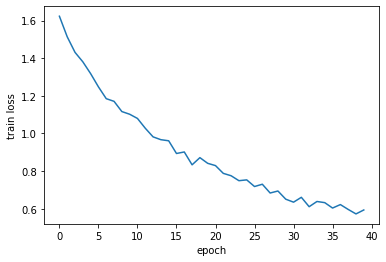

In [24]:
plt.plot(range(len(train_loss_history)), train_loss_history)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

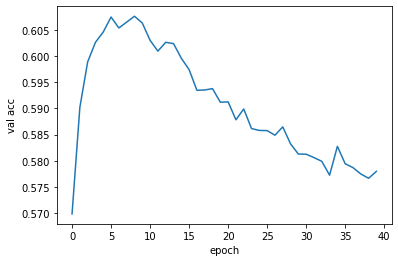

In [25]:
plt.plot(range(len(val_acc_history)), val_acc_history)
plt.xlabel('epoch')
plt.ylabel('val acc')
plt.show

## Norm model without and with glorot initialization

In [13]:
norm_model = torch_models.NormModel()
optimizer = optim.Adam(norm_model.parameters())
writer = SummaryWriter('runs/norm_bs2048_rs42')

EPOCHS = 60
for epoch in range(EPOCHS):
    loss_sum = 0.0
    loss_count = 0
        
    for x_img_cur, x_txt_cur, y_cur in train_loader:
        norm_model.zero_grad()
        output = norm_model(x_img_cur.view(-1, IMG_LEN).float(), x_txt_cur.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y_cur, dim=1))
        loss.backward()
            
        loss_sum += loss
        loss_count += 1
            
        optimizer.step()

    print('epoch:', epoch, 'train_loss:', loss, 'average train loss', loss_sum/loss_count)
    writer.add_scalar('train_loss', loss, epoch)
    writer.add_scalar('avg_train_loss', loss_sum/loss_count, epoch)

    correct = 0
    total = 0
    loss_sum = 0.0
    loss_count = 0
        
    with torch.no_grad():
        for x_img_cur, x_txt_cur, y_cur in val_loader:
            output = norm_model(x_img_cur.view(-1, IMG_LEN).float(), x_txt_cur.view(-1, TXT_LEN).float())
            loss = F.nll_loss(output, torch.argmax(y_cur, dim=1))
            loss_sum += loss
            loss_count += 1
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y_cur, dim=1)[idx]:
                    correct += 1
                total += 1

    print('val_acc:', correct/total, 'val_avg_loss:', loss_sum/loss_count)
    writer.add_scalar('val_acc', correct/total, epoch)
    writer.add_scalar('val_avg_loss', loss_sum/loss_count, epoch)

epoch: 0 train_loss: tensor(1.7752, grad_fn=<NllLossBackward>) average train loss tensor(2.4701, grad_fn=<DivBackward0>)
val_acc: 0.5220897718910964 val_avg_loss: tensor(1.7794)
epoch: 1 train_loss: tensor(1.5299, grad_fn=<NllLossBackward>) average train loss tensor(1.6370, grad_fn=<DivBackward0>)
val_acc: 0.5727152317880795 val_avg_loss: tensor(1.6000)
epoch: 2 train_loss: tensor(1.4072, grad_fn=<NllLossBackward>) average train loss tensor(1.5169, grad_fn=<DivBackward0>)
val_acc: 0.5837527593818984 val_avg_loss: tensor(1.5512)
epoch: 3 train_loss: tensor(1.3170, grad_fn=<NllLossBackward>) average train loss tensor(1.4603, grad_fn=<DivBackward0>)
val_acc: 0.5924944812362031 val_avg_loss: tensor(1.5152)
epoch: 4 train_loss: tensor(1.2620, grad_fn=<NllLossBackward>) average train loss tensor(1.4157, grad_fn=<DivBackward0>)
val_acc: 0.5956732891832229 val_avg_loss: tensor(1.5054)
epoch: 5 train_loss: tensor(1.1793, grad_fn=<NllLossBackward>) average train loss tensor(1.3825, grad_fn=<DivB

epoch: 46 train_loss: tensor(0.4211, grad_fn=<NllLossBackward>) average train loss tensor(0.8343, grad_fn=<DivBackward0>)
val_acc: 0.5754231052244297 val_avg_loss: tensor(1.8778)
epoch: 47 train_loss: tensor(0.4011, grad_fn=<NllLossBackward>) average train loss tensor(0.8253, grad_fn=<DivBackward0>)
val_acc: 0.5758351729212656 val_avg_loss: tensor(1.8808)
epoch: 48 train_loss: tensor(0.4084, grad_fn=<NllLossBackward>) average train loss tensor(0.8225, grad_fn=<DivBackward0>)
val_acc: 0.5801324503311258 val_avg_loss: tensor(1.9113)
epoch: 49 train_loss: tensor(0.4165, grad_fn=<NllLossBackward>) average train loss tensor(0.8198, grad_fn=<DivBackward0>)
val_acc: 0.5775717439293598 val_avg_loss: tensor(1.8919)
epoch: 50 train_loss: tensor(0.3899, grad_fn=<NllLossBackward>) average train loss tensor(0.8116, grad_fn=<DivBackward0>)
val_acc: 0.5785430463576159 val_avg_loss: tensor(1.8943)
epoch: 51 train_loss: tensor(0.3849, grad_fn=<NllLossBackward>) average train loss tensor(0.8036, grad_fn

In [16]:
model = torch_models.NormModel()
optimizer = optim.Adam(model.parameters())
writer = SummaryWriter('runs/norm_bs2048_rs42_te')

EPOCHS = 60
for epoch in range(EPOCHS):
    model.train()
    
    loss_sum = 0.0
    loss_count = 0
        
    for x_img_cur, x_txt_cur, y_cur in train_loader:
        model.zero_grad()
        output = model(x_img_cur.view(-1, IMG_LEN).float(), x_txt_cur.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y_cur, dim=1))
        loss.backward()
            
        loss_sum += loss
        loss_count += 1
            
        optimizer.step()

    print('epoch:', epoch, 'train_loss:', loss, 'average train loss', loss_sum/loss_count)
    writer.add_scalar('train_loss', loss, epoch)
    writer.add_scalar('avg_train_loss', loss_sum/loss_count, epoch)

    model.eval()
    
    correct = 0
    total = 0
    loss_sum = 0.0
    loss_count = 0
        
    with torch.no_grad():
        for x_img_cur, x_txt_cur, y_cur in val_loader:
            output = model(x_img_cur.view(-1, IMG_LEN).float(), x_txt_cur.view(-1, TXT_LEN).float())
            loss = F.nll_loss(output, torch.argmax(y_cur, dim=1))
            loss_sum += loss
            loss_count += 1
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y_cur, dim=1)[idx]:
                    correct += 1
                total += 1

    print('val_acc:', correct/total, 'val_avg_loss:', loss_sum/loss_count)
    writer.add_scalar('val_acc', correct/total, epoch)
    writer.add_scalar('val_avg_loss', loss_sum/loss_count, epoch)

epoch: 0 train_loss: tensor(1.7957, grad_fn=<NllLossBackward>) average train loss tensor(2.4653, grad_fn=<DivBackward0>)
val_acc: 0.557645327446652 val_avg_loss: tensor(1.6393)
epoch: 1 train_loss: tensor(1.5437, grad_fn=<NllLossBackward>) average train loss tensor(1.6360, grad_fn=<DivBackward0>)
val_acc: 0.600794701986755 val_avg_loss: tensor(1.4760)
epoch: 2 train_loss: tensor(1.4197, grad_fn=<NllLossBackward>) average train loss tensor(1.5206, grad_fn=<DivBackward0>)
val_acc: 0.6118322295805739 val_avg_loss: tensor(1.4222)
epoch: 3 train_loss: tensor(1.3667, grad_fn=<NllLossBackward>) average train loss tensor(1.4615, grad_fn=<DivBackward0>)
val_acc: 0.6181898454746136 val_avg_loss: tensor(1.3941)
epoch: 4 train_loss: tensor(1.3017, grad_fn=<NllLossBackward>) average train loss tensor(1.4181, grad_fn=<DivBackward0>)
val_acc: 0.6222222222222222 val_avg_loss: tensor(1.3750)
epoch: 5 train_loss: tensor(1.2260, grad_fn=<NllLossBackward>) average train loss tensor(1.3819, grad_fn=<DivBac

epoch: 46 train_loss: tensor(0.4172, grad_fn=<NllLossBackward>) average train loss tensor(0.8394, grad_fn=<DivBackward0>)
val_acc: 0.6233406916850626 val_avg_loss: tensor(1.5579)
epoch: 47 train_loss: tensor(0.4006, grad_fn=<NllLossBackward>) average train loss tensor(0.8335, grad_fn=<DivBackward0>)
val_acc: 0.6228108903605593 val_avg_loss: tensor(1.5577)
epoch: 48 train_loss: tensor(0.4100, grad_fn=<NllLossBackward>) average train loss tensor(0.8283, grad_fn=<DivBackward0>)
val_acc: 0.6227520235467255 val_avg_loss: tensor(1.5711)
epoch: 49 train_loss: tensor(0.4124, grad_fn=<NllLossBackward>) average train loss tensor(0.8236, grad_fn=<DivBackward0>)
val_acc: 0.6206328182487123 val_avg_loss: tensor(1.5631)
epoch: 50 train_loss: tensor(0.4134, grad_fn=<NllLossBackward>) average train loss tensor(0.8104, grad_fn=<DivBackward0>)
val_acc: 0.6222222222222222 val_avg_loss: tensor(1.5811)
epoch: 51 train_loss: tensor(0.3769, grad_fn=<NllLossBackward>) average train loss tensor(0.8054, grad_fn

In [12]:
norm_model_glorot = torch_models.NormModelGlorot()
optimizer = optim.Adam(norm_model_glorot.parameters())
writer = SummaryWriter('runs/glorot_bs2048_rs42')

EPOCHS = 60
for epoch in range(EPOCHS):
    loss_sum = 0.0
    loss_count = 0
        
    for x_img_cur, x_txt_cur, y_cur in train_loader:
        norm_model_glorot.zero_grad()
        output = norm_model_glorot(x_img_cur.view(-1, IMG_LEN).float(), x_txt_cur.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y_cur, dim=1))
        loss.backward()
            
        loss_sum += loss
        loss_count += 1
            
        optimizer.step()

    print('epoch:', epoch, 'train_loss:', loss, 'average train loss', loss_sum/loss_count)
    writer.add_scalar('train_loss', loss, epoch)
    writer.add_scalar('avg_train_loss', loss_sum/loss_count, epoch)

    correct = 0
    total = 0
    loss_sum = 0.0
    loss_count = 0
        
    with torch.no_grad():
        for x_img_cur, x_txt_cur, y_cur in val_loader:
            output = norm_model_glorot(x_img_cur.view(-1, IMG_LEN).float(), x_txt_cur.view(-1, TXT_LEN).float())
            loss = F.nll_loss(output, torch.argmax(y_cur, dim=1))
            loss_sum += loss
            loss_count += 1
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y_cur, dim=1)[idx]:
                    correct += 1
                total += 1

    print('val_acc:', correct/total, 'val_avg_loss:', loss_sum/loss_count)
    writer.add_scalar('val_acc', correct/total, epoch)
    writer.add_scalar('val_avg_loss', loss_sum/loss_count, epoch)

[autoreload of pytorch.torch_models failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.7/site-packages/IPyt

epoch: 0 train_loss: tensor(1.8598, grad_fn=<NllLossBackward>) average train loss tensor(2.4385, grad_fn=<DivBackward0>)
val_acc: 0.5201471670345843 val_avg_loss: tensor(1.8433)
epoch: 1 train_loss: tensor(1.6297, grad_fn=<NllLossBackward>) average train loss tensor(1.7092, grad_fn=<DivBackward0>)
val_acc: 0.560794701986755 val_avg_loss: tensor(1.6661)
epoch: 2 train_loss: tensor(1.4839, grad_fn=<NllLossBackward>) average train loss tensor(1.5836, grad_fn=<DivBackward0>)
val_acc: 0.572214863870493 val_avg_loss: tensor(1.6083)
epoch: 3 train_loss: tensor(1.3660, grad_fn=<NllLossBackward>) average train loss tensor(1.5142, grad_fn=<DivBackward0>)
val_acc: 0.5838116261957321 val_avg_loss: tensor(1.5732)
epoch: 4 train_loss: tensor(1.3545, grad_fn=<NllLossBackward>) average train loss tensor(1.4656, grad_fn=<DivBackward0>)
val_acc: 0.5886975717439293 val_avg_loss: tensor(1.5499)
epoch: 5 train_loss: tensor(1.2384, grad_fn=<NllLossBackward>) average train loss tensor(1.4241, grad_fn=<DivBac

epoch: 46 train_loss: tensor(0.4804, grad_fn=<NllLossBackward>) average train loss tensor(0.8800, grad_fn=<DivBackward0>)
val_acc: 0.5796026490066225 val_avg_loss: tensor(1.8004)
epoch: 47 train_loss: tensor(0.4793, grad_fn=<NllLossBackward>) average train loss tensor(0.8779, grad_fn=<DivBackward0>)
val_acc: 0.5827225901398086 val_avg_loss: tensor(1.7879)
epoch: 48 train_loss: tensor(0.4605, grad_fn=<NllLossBackward>) average train loss tensor(0.8664, grad_fn=<DivBackward0>)
val_acc: 0.5828991905813098 val_avg_loss: tensor(1.7934)
epoch: 49 train_loss: tensor(0.4310, grad_fn=<NllLossBackward>) average train loss tensor(0.8632, grad_fn=<DivBackward0>)
val_acc: 0.5838116261957321 val_avg_loss: tensor(1.7948)
epoch: 50 train_loss: tensor(0.4320, grad_fn=<NllLossBackward>) average train loss tensor(0.8557, grad_fn=<DivBackward0>)
val_acc: 0.5816924208977189 val_avg_loss: tensor(1.8043)
epoch: 51 train_loss: tensor(0.4372, grad_fn=<NllLossBackward>) average train loss tensor(0.8503, grad_fn

In [22]:
norm_model_4 = torch_models.NormModel()
optimizer = optim.Adam(norm_model_4.parameters(), lr=1e-4)
norm_4_writer = SummaryWriter()

In [23]:
EPOCHS = 20
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model_4.zero_grad()
        output = norm_model_4(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model_4(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    norm_4_writer.add_scalar('/accuracy/val/norm_4', correct/total, epoch)

In [24]:
norm_model_2 = torch_models.NormModel()
optimizer = optim.Adam(norm_model_2.parameters(), lr=1e-2)
norm_2_writer = SummaryWriter()

In [25]:
EPOCHS = 20
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model_2.zero_grad()
        output = norm_model_2(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model_2(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    norm_2_writer.add_scalar('accuracy/val/norm_2', correct/total, epoch)

In [28]:
norm_model_s = torch_models.NormModel()
optimizer = optim.Adam(norm_model_s.parameters(), lr=1e-3)
cos_shed = optim.lr_scheduler.CosineAnnealingLR(optimizer, 2000) 
writer = SummaryWriter()

In [29]:
EPOCHS = 20
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model_s.zero_grad()
        output = norm_model_s(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
        cos_shed.step()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model_s(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    writer.add_scalar('accuracy/val/norm_s', correct/total, epoch)

In [31]:
norm_model_cs = torch_models.NormModel()
optimizer = optim.Adam(norm_model_cs.parameters(), lr=1e-3)
cyclic_shed = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-2, cycle_momentum=False) 
writer = SummaryWriter()

In [32]:
EPOCHS = 20
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model_cs.zero_grad()
        output = norm_model_cs(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
        cyclic_shed.step()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model_cs(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    writer.add_scalar('accuracy/val/norm_cs', correct/total, epoch)

In [33]:
with torch.no_grad():
    for x_img, x_txt, y in val_loader:
        output = norm_model_cs(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        for idx, i in enumerate(output):
            if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                correct += 1
            total += 1
            
print(correct/total)

0.5671376011773362


## Rectified ADAM

In [29]:
norm_model_radam = torch_models.NormModel()
optimizer = radam.RAdam(norm_model_radam.parameters())
writer = SummaryWriter('runs/radam')

In [30]:
EPOCHS = 40
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model_radam.zero_grad()
        output = norm_model_radam(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
    
    writer.add_scalar('train_loss', loss, epoch)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model_radam(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    writer.add_scalar('val_acc', correct/total, epoch)

In [18]:
model = torch_models.NormModel()
optimizer = radam.RAdam(model.parameters())
writer = SummaryWriter('runs/norm_radam_bs2048_rs42_te')

EPOCHS = 60
for epoch in range(EPOCHS):
    model.train()
    
    loss_sum = 0.0
    loss_count = 0
        
    for x_img_cur, x_txt_cur, y_cur in train_loader:
        model.zero_grad()
        output = model(x_img_cur.view(-1, IMG_LEN).float(), x_txt_cur.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y_cur, dim=1))
        loss.backward()
            
        loss_sum += loss
        loss_count += 1
            
        optimizer.step()

    print('epoch:', epoch, 'train_loss:', loss, 'average train loss', loss_sum/loss_count)
    writer.add_scalar('train_loss', loss, epoch)
    writer.add_scalar('avg_train_loss', loss_sum/loss_count, epoch)

    model.eval()
    
    correct = 0
    total = 0
    loss_sum = 0.0
    loss_count = 0
        
    with torch.no_grad():
        for x_img_cur, x_txt_cur, y_cur in val_loader:
            output = model(x_img_cur.view(-1, IMG_LEN).float(), x_txt_cur.view(-1, TXT_LEN).float())
            loss = F.nll_loss(output, torch.argmax(y_cur, dim=1))
            loss_sum += loss
            loss_count += 1
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y_cur, dim=1)[idx]:
                    correct += 1
                total += 1

    print('val_acc:', correct/total, 'val_avg_loss:', loss_sum/loss_count)
    writer.add_scalar('val_acc', correct/total, epoch)
    writer.add_scalar('val_avg_loss', loss_sum/loss_count, epoch)

[autoreload of pytorch.torch_models failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importl

epoch: 0 train_loss: tensor(3.3168, grad_fn=<NllLossBackward>) average train loss tensor(3.7594, grad_fn=<DivBackward0>)
val_acc: 0.20559234731420162 val_avg_loss: tensor(3.2530)
epoch: 1 train_loss: tensor(2.1050, grad_fn=<NllLossBackward>) average train loss tensor(2.5946, grad_fn=<DivBackward0>)
val_acc: 0.48562178072111845 val_avg_loss: tensor(1.9317)
epoch: 2 train_loss: tensor(1.7373, grad_fn=<NllLossBackward>) average train loss tensor(1.8748, grad_fn=<DivBackward0>)
val_acc: 0.5659455481972038 val_avg_loss: tensor(1.6185)
epoch: 3 train_loss: tensor(1.5961, grad_fn=<NllLossBackward>) average train loss tensor(1.6674, grad_fn=<DivBackward0>)
val_acc: 0.5930537159676232 val_avg_loss: tensor(1.5093)
epoch: 4 train_loss: tensor(1.4828, grad_fn=<NllLossBackward>) average train loss tensor(1.5734, grad_fn=<DivBackward0>)
val_acc: 0.6037086092715231 val_avg_loss: tensor(1.4619)
epoch: 5 train_loss: tensor(1.4484, grad_fn=<NllLossBackward>) average train loss tensor(1.5199, grad_fn=<Di

epoch: 46 train_loss: tensor(0.4846, grad_fn=<NllLossBackward>) average train loss tensor(0.8897, grad_fn=<DivBackward0>)
val_acc: 0.6238704930095659 val_avg_loss: tensor(1.5161)
epoch: 47 train_loss: tensor(0.4630, grad_fn=<NllLossBackward>) average train loss tensor(0.8815, grad_fn=<DivBackward0>)
val_acc: 0.6214569536423841 val_avg_loss: tensor(1.5247)
epoch: 48 train_loss: tensor(0.4678, grad_fn=<NllLossBackward>) average train loss tensor(0.8729, grad_fn=<DivBackward0>)
val_acc: 0.6202501839587933 val_avg_loss: tensor(1.5314)
epoch: 49 train_loss: tensor(0.4596, grad_fn=<NllLossBackward>) average train loss tensor(0.8637, grad_fn=<DivBackward0>)
val_acc: 0.622869757174393 val_avg_loss: tensor(1.5483)
epoch: 50 train_loss: tensor(0.4563, grad_fn=<NllLossBackward>) average train loss tensor(0.8621, grad_fn=<DivBackward0>)
val_acc: 0.6211037527593819 val_avg_loss: tensor(1.5472)
epoch: 51 train_loss: tensor(0.4353, grad_fn=<NllLossBackward>) average train loss tensor(0.8485, grad_fn=

In [31]:
torch.save({
    'epoch' : 40,
    'model_state_dict' : norm_model_radam.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),    
}, 'saved_models/torch/radam')

## Plain RADAM

In [32]:
norm_model_plain_radam = torch_models.NormModel()
optimizer = radam.PlainRAdam(norm_model_radam.parameters())
writer = SummaryWriter('runs/plain_radam')

In [33]:
EPOCHS = 40
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model_plain_radam.zero_grad()
        output = norm_model_plain_radam(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
    
    writer.add_scalar('train_loss', loss, epoch)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model_plain_radam(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    writer.add_scalar('val_acc', correct/total, epoch)

In [34]:
torch.save({
    'epoch' : 40,
    'model_state_dict' : norm_model_plain_radam.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),    
}, 'saved_models/torch/radam')

## AdamW

In [35]:
norm_model_adamw = torch_models.NormModel()
optimizer = radam.AdamW(norm_model_adamw.parameters())
writer = SummaryWriter('runs/adamw')

In [36]:
EPOCHS = 40
for epoch in range(EPOCHS):
    for x_img, x_txt, y in train_loader:
        norm_model_adamw.zero_grad()
        output = norm_model_adamw(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
        loss = F.nll_loss(output, torch.argmax(y, dim=1))
        loss.backward()
        optimizer.step()
    
    writer.add_scalar('train_loss', loss, epoch)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model_adamw(x_img.view(-1, IMG_LEN).float(), x_txt.view(-1, TXT_LEN).float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
                
    writer.add_scalar('val_acc', correct/total, epoch)

In [37]:
torch.save({
    'epoch' : 40,
    'model_state_dict' : norm_model_adamw.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),    
}, 'saved_models/torch/adamw')